## SkimLit Project

> `The purpose is to build an NLP model which makes reading of medical abstracts easier`

> The paper we are replicating or from where we are getting the dataset is from: https://arxiv.org/abs/1710.06071

> From the above paper, we can see that the `model architecture` they have implemented to achive the best results is from: https://arxiv.org/pdf/1612.05251.pdf

> The dartaset we will be using is from the above paper(`PubMed 200k RCT`)

> The dataset is freely available on `Github`: https://github.com/Franck-Dernoncourt/pubmed-rct

## Getting the data

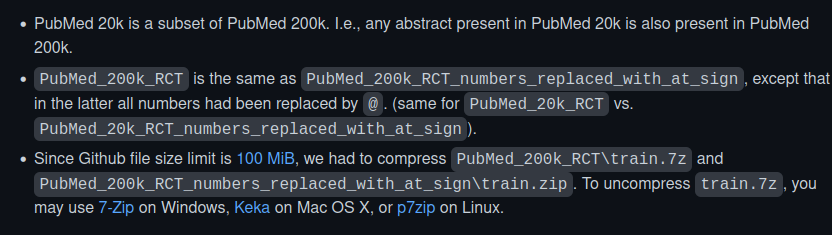

## Helper Function

In [1]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-26 12:37:22--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19296 (19K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  18.84K  --.-KB/s    in 0s      

2022-08-26 12:37:22 (50.3 MB/s) - ‘helper_functions.py’ saved [19296/19296]



In [2]:
from helper_functions import unzip_data, plot_loss_curves, make_confusion_matrix, calculate_results, create_tensorboard_callback

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


In [4]:
!ls /content/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


## Using the `PubMed 20K RCT with number replaced with "@" sign`

In [5]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

### Filenames in the directory

In [6]:
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
os.listdir(data_dir)

['dev.txt', 'train.txt', 'test.txt']

In [8]:
filenames[0]

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'

## Preprocessing data

> Function to read in all of the lines of a target text file. 

In [9]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

### Reading the `training dataset` lines

In [10]:
train_lines=get_lines(filenames[0])
len(train_lines), train_lines[:30]

(35212,
 ['###24290286\n',
  'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
  'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
  'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
  'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
  'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
  'RESULTS\tSixty-five patients we

### Preprocessing Function

#### Example

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [11]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
      # print(abstract_line_split)

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [12]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 682 ms, sys: 108 ms, total: 790 ms
Wall time: 1.12 s


(180040, 30212, 30135)

In [13]:
train_samples[:20]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

## Visualizing the dataset

In [14]:
import pandas as pd
import numpy as np

In [15]:
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df= pd.DataFrame(test_samples)

In [16]:
train_df[:25]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### Target Distribution

In [17]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

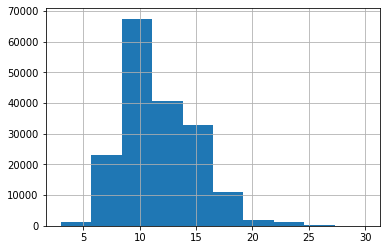

In [18]:
train_df['total_lines'].hist()

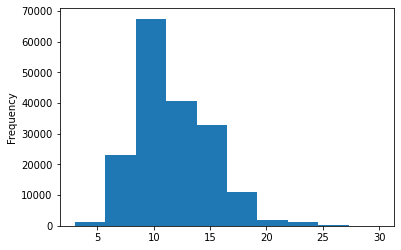

In [19]:
train_df['total_lines'].plot.hist()

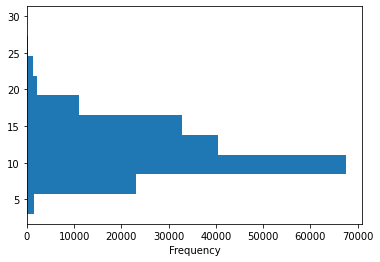

In [20]:
train_df['total_lines'].plot.hist(orientation='horizontal')

In [21]:
train_df['total_lines'].mean()

11.789135747611642

In [22]:
train_df['total_lines'].median()

11.0

In [23]:
train_sentences= train_df['text'].tolist()
val_sentences= val_df['text'].tolist()
test_sentences= test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [24]:
train_sentences[:11]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numerical labels

> Machine Learning model require numerical labels

In [25]:
import sklearn
print(sklearn.__version__)

1.0.2


### One Hot Encoded labels

In [26]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder= OneHotEncoder(sparse=False)  # We want a non-sparse matrix. Tensorflow or tensor is not compatiable with sparse matrix
train_labels_one_hot= one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot= one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot= one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [27]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [28]:
train_labels_one_hot.shape

(180040, 5)

### Label encode `The target labels` 

> Extract labels `target columns` and encode them into integers. Encoding the `string/text` into `numbers`

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder= LabelEncoder()
train_labels_encoder= label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoder= label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoder= label_encoder.transform(test_df['target'].to_numpy())

In [30]:
train_labels_encoder

array([3, 2, 2, ..., 4, 1, 1])

## Getting the class Names

In [31]:
num_classes= len(label_encoder.classes_)
class_names= label_encoder.classes_

class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object), 5)

## Model 0: Baseline Model

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [33]:
model_0= Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoder)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

### Evaluating the model

In [34]:
baseline_score= model_0.score(val_sentences, val_labels_encoder)
baseline_score

0.7218323844829869

### Making Predictions

In [35]:
baseline_preds= model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Baseline Results

In [36]:
baseline_results=calculate_results(val_labels_encoder, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Text Vectorization

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [38]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

26

### Checking the length of the sentences

In [39]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len 

26.338269273494777

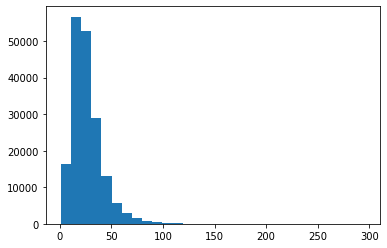

In [40]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

### Checking which length covers about 95% of the sentences

In [41]:
output_sequence_length= int(np.percentile(sent_lens, 95))
output_sequence_length

55

In [42]:
min(sent_lens), max(sent_lens)

(1, 296)

In [43]:
max_length=round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

26

## Conclusion

> `26` would have been fine but `55` covers all `95%` of the sentences in the training data. So setting `output_sequence_length` to `55` would be better than `26`. 

In [44]:
max_vocab_length= 68000 # Taken from `Table 2` of the paper
max_length=output_sequence_length

text_vectorizer= TextVectorization(
    max_tokens= max_vocab_length, 
    output_sequence_length=max_length,
)

In [45]:
text_vectorizer

In [46]:
text_vectorizer.adapt(train_sentences)

In [47]:
sample_text="I am currently learning about Natural Language Processing in Machine Learning."
text_vectorizer([sample_text])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 389, 2651, 1325,  953,  338, 2266, 2111, 2573,    5, 9386,  953,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

### Words in the vocabulary

In [48]:
text_vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'of',
 'in',
 'to',
 'with',
 'a',
 'were',
 'was',
 'for',
 'patients',
 'group',
 'p',
 'at',
 'or',
 'study',
 'on',
 'treatment',
 'is',
 'after',
 'by',
 'this',
 'groups',
 'as',
 'an',
 'from',
 'that',
 'randomized',
 'between',
 'not',
 'trial',
 'no',
 'compared',
 'control',
 'be',
 'significant',
 'intervention',
 'significantly',
 'n',
 'months',
 'than',
 'we',
 'vs',
 'rsb',
 'lsb',
 'clinical',
 'placebo',
 'baseline',
 'ci',
 'two',
 'during',
 'weeks',
 'both',
 'had',
 'primary',
 'mean',
 'are',
 'using',
 'participants',
 'there',
 'all',
 'time',
 'years',
 'pain',
 'therapy',
 'who',
 'mg',
 'more',
 'effect',
 'effects',
 'but',
 'risk',
 'difference',
 'outcomes',
 'total',
 'care',
 'rate',
 'efficacy',
 'received',
 'associated',
 'higher',
 'respectively',
 'days',
 'analysis',
 'outcome',
 'use',
 'one',
 'week',
 'women',
 'may',
 'randomly',
 'levels',
 'followup',
 'will',
 'increased',
 'health',
 'used',
 'have',
 'data'

### Length of the Vocabulary

In [49]:
rct_20k_text_vocab_len=len(text_vectorizer.get_vocabulary())
rct_20k_text_vocab_len

64841

### Most Common Words

In [50]:
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

### Least Common words

In [51]:
text_vectorizer.get_vocabulary()[-5:]

['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']

## Found some inconsistency in `text_vectorizer.get_config()` 

### From Video

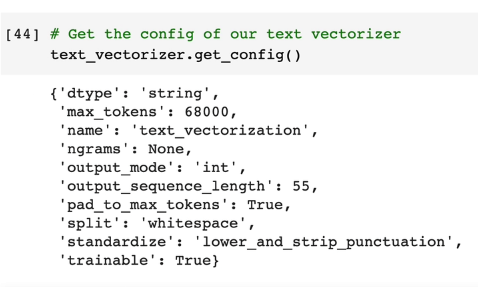


### From My Notebook
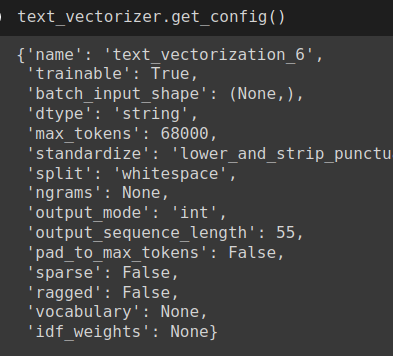

### Configuration of the Text Vectorizer 

In [52]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

## Embedding Layer

In [53]:
max_vocab_length

68000

In [54]:
rct_20k_text_vocab_len

64841

In [55]:
max_length

55

In [56]:
from tensorflow.keras import layers

embedding= layers.Embedding(input_dim=rct_20k_text_vocab_len, output_dim=128, mask_zero=True , name="token_embedding")

In [57]:
embedding

### Embedding Example

In [58]:
# Show example embedding
print(f"Sentence before vectorization:\n{sample_text}\n")
vectorized_sentence = text_vectorizer([sample_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
I am currently learning about Natural Language Processing in Machine Learning.

Sentence after vectorization (before embedding):
[[ 389 2651 1325  953  338 2266 2111 2573    5 9386  953    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.01885612  0.03071428 -0.02057834 ...  0.02125963  0.04572615
   -0.00735511]
  [-0.0431942   0.04770699  0.02870091 ...  0.0051282  -0.02408259
   -0.04418625]
  [ 0.00794604 -0.03202239  0.03101685 ... -0.04038291  0.00387638
   -0.01088283]
  ...
  [-0.01403327 -0.0123058  -0.03366049 ...  0.01695502  0.02120182
    0.00955151]
  [-0.01403327 -0.0123058  -0.03366049 ...  0.01695502  0.02120182
    0.00955151]
  [-0.01403327 -0.0123058  -0.03366049 ...  0.01695502  0.02120182
    0.00955151]]]

Embedded sentence sha

## Making Datasets load as fast as possible

In [59]:
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset= tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset= tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [60]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [61]:
train_labels_one_hot.shape

(180040, 5)

In [62]:
train_labels_one_hot[0]

array([0., 0., 0., 1., 0.])

### Turning the dataset into prefetched datasets

> We are not shuffeling the `training dataset` as we are building a model for `seq2seq` or `sequence2sequence` problems where the sequences matter.

In [63]:
train_dataset= train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset= val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset= test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [65]:
num_classes

5

In [66]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [67]:
inputs= layers.Input(shape=(1,), dtype="string")
x= text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x=layers.GlobalAveragePooling1D(name="global_average_pooling1D")(x)
x=layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_1= tf.keras.Model(inputs, outputs, name="conv1D_with_token_embeddings")


In [68]:
model_1.summary()

Model: "conv1D_with_token_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1D (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64

In [69]:
SAVE_DIR="model_logs"

In [70]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
len(train_dataset)

5627

In [72]:
len(train_dataset) * 32

180064

In [73]:
int(0.1 * len(train_dataset))

562

In [74]:
model_1.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_1= model_1.fit(train_dataset, steps_per_epoch=int(0.1 * len(train_dataset)) ,epochs=5, validation_data=val_dataset, validation_steps=int(0.1 * len(val_dataset)) ,callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_Conv1D_token_embeddings")])

Saving TensorBoard log files to: model_logs/model_1_Conv1D_token_embeddings/20220826-123816
Epoch 1/5
562/562 [==============================] - 18s 9ms/step - loss: 0.8729 - accuracy: 0.6454 - val_loss: 0.6630 - val_accuracy: 0.7424
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6453 - accuracy: 0.7512 - val_loss: 0.6257 - val_accuracy: 0.7610
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6039 - accuracy: 0.7714 - val_loss: 0.5712 - val_accuracy: 0.7862
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5717 - accuracy: 0.7895 - val_loss: 0.5500 - val_accuracy: 0.7916
Epoch 5/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5726 - accuracy: 0.7903 - val_loss: 0.5324 - val_accuracy: 0.8052


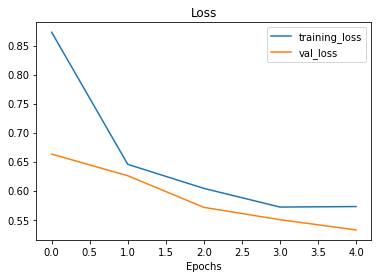

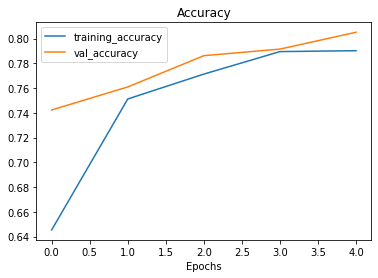

In [75]:
plot_loss_curves(history_1)

### Evaluating the model

In [76]:
model_1_evaluate= model_1.evaluate(val_dataset)
model_1_evaluate

945/945 [==============================] - 3s 3ms/step - loss: 0.5366 - accuracy: 0.8031


[0.5365779995918274, 0.803058385848999]

In [77]:
model_1_pred_probs= model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[5.1368672e-01, 2.2596058e-01, 2.3714086e-02, 1.8559161e-01,
         5.1047042e-02],
        [4.5479938e-01, 3.7880456e-01, 6.9240243e-03, 1.3782634e-01,
         2.1645626e-02],
        [2.2090866e-01, 6.1764796e-03, 1.3738147e-02, 7.5851315e-01,
         6.6353270e-04],
        ...,
        [7.0926042e-05, 1.0138525e-03, 6.0870755e-03, 2.5883282e-05,
         9.9280220e-01],
        [7.4028715e-02, 4.7984850e-01, 8.3479613e-02, 6.7896537e-02,
         2.9474661e-01],
        [8.8087514e-02, 8.6599010e-01, 1.6486740e-02, 9.1151819e-03,
         2.0320427e-02]], dtype=float32), (30212, 5))

In [78]:
model_1_preds= tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [79]:
model_1_results= calculate_results(val_labels_encoder,model_1_preds)
model_1_results

{'accuracy': 80.30583873957367,
 'precision': 0.802563736889889,
 'recall': 0.8030583873957368,
 'f1': 0.8012744411922774}

In [80]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Tensorflow Hub Pre-trained Feature Extractor

> Model Link(`USE`) -> https://tfhub.dev/google/universal-sentence-encoder/4

In [81]:
model_url='https://tfhub.dev/google/universal-sentence-encoder/4'

In [82]:
import tensorflow_hub as hub

### Sentence Encoder Layer

In [83]:
sentence_encoder_layer= hub.KerasLayer(model_url, input_shape=[], dtype="string", trainable=False, name="transfer_learning_USE")

In [84]:
model_2= tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(num_classes, activation="softmax")
], name="USE_feature_extractor")

In [85]:
model_2.summary()

Model: "USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transfer_learning_USE (Kera  (None, 512)              256797824 
 sLayer)                                                         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [86]:
model_2.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_2= model_2.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)), validation_data= val_dataset, validation_steps= int(0.1 * len(val_dataset)), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_USE_feature_extractor")])

Saving TensorBoard log files to: model_logs/model_2_USE_feature_extractor/20220826-123918
Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 1.2560 - accuracy: 0.5519 - val_loss: 1.0831 - val_accuracy: 0.6001
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 1.0100 - accuracy: 0.6267 - val_loss: 0.9543 - val_accuracy: 0.6499
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.9308 - accuracy: 0.6559 - val_loss: 0.8950 - val_accuracy: 0.6762
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.8737 - accuracy: 0.6775 - val_loss: 0.8620 - val_accuracy: 0.6795
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.8631 - accuracy: 0.6773 - val_loss: 0.8407 - val_accuracy: 0.6842


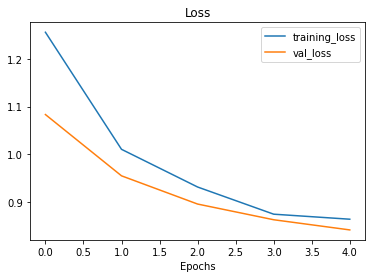

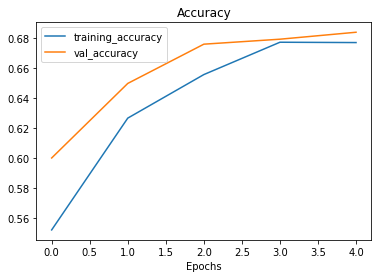

In [87]:
plot_loss_curves(history_2)

In [88]:
model_2_evaluate=model_2.evaluate(val_dataset)
model_2_evaluate

945/945 [==============================] - 10s 10ms/step - loss: 0.8390 - accuracy: 0.6877


[0.8389701843261719, 0.6876737475395203]

In [89]:
model_2_pred_probs= model_2.predict(val_dataset)
model_2_pred_probs

array([[0.48024443, 0.28851816, 0.02719452, 0.14710271, 0.05694027],
       [0.3887494 , 0.46573836, 0.01855575, 0.09074608, 0.0362105 ],
       [0.25533098, 0.25614423, 0.0746087 , 0.29960272, 0.11431338],
       ...,
       [0.01034419, 0.00921315, 0.15223019, 0.00598528, 0.8222271 ],
       [0.02592165, 0.06190941, 0.35219684, 0.01102558, 0.5489465 ],
       [0.21523991, 0.09331981, 0.5033941 , 0.02036783, 0.1676783 ]],
      dtype=float32)

In [90]:
model_2_preds= tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [91]:
model_2_results= calculate_results(val_labels_encoder, model_2_preds)
model_2_results

{'accuracy': 68.76737720111214,
 'precision': 0.6790364740175273,
 'recall': 0.6876737720111215,
 'f1': 0.6782531204502598}

In [92]:
model_1_results

{'accuracy': 80.30583873957367,
 'precision': 0.802563736889889,
 'recall': 0.8030583873957368,
 'f1': 0.8012744411922774}

In [93]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2_1: Tensorflow Hub Pre-trained Feature Extractor

> Model Link(`USE`) -> https://tfhub.dev/google/universal-sentence-encoder/4

In [94]:
tf_hub_embedding_layer = hub.KerasLayer(model_url,trainable=False, name="universal_sentence_encoder")

In [96]:
inputs= layers.Input(shape=[], dtype="string")
pretrained_embedding= tf_hub_embedding_layer(inputs)
x= layers.Dense(128, activation="relu")(pretrained_embedding)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model_2_1= tf.keras.Model(inputs, outputs, name="USE_feature_extraction_with_sequential_API")

model_2_1.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=tf.keras.optimizers.Adam())

In [97]:
model_2_1.summary()

Model: "USE_feature_extraction_with_sequential_API"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [98]:
history_2_1= model_2_1.fit(train_dataset, epochs=5, steps_per_epoch=int(0.1 * len(train_dataset)), validation_data= val_dataset, validation_steps= int(0.1 * len(val_dataset)), callbacks=[create_tensorboard_callback(SAVE_DIR, "model_2_1_USE_feature_extractor")])

Saving TensorBoard log files to: model_logs/model_2_1_USE_feature_extractor/20220826-125930
Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9142 - accuracy: 0.6492 - val_loss: 0.7957 - val_accuracy: 0.6885
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7676 - accuracy: 0.7018 - val_loss: 0.7536 - val_accuracy: 0.7038
Epoch 3/5
562/562 [==============================] - 10s 17ms/step - loss: 0.7503 - accuracy: 0.7127 - val_loss: 0.7359 - val_accuracy: 0.7144
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7172 - accuracy: 0.7244 - val_loss: 0.7084 - val_accuracy: 0.7271
Epoch 5/5
562/562 [==============================] - 10s 17ms/step - loss: 0.7247 - accuracy: 0.7224 - val_loss: 0.6884 - val_accuracy: 0.7327


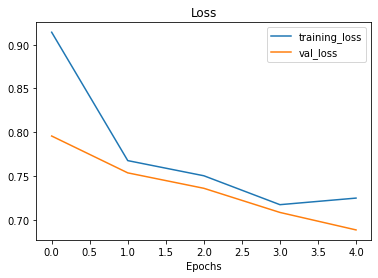

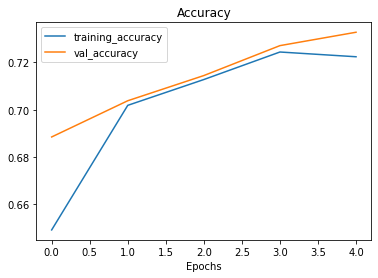

In [99]:
plot_loss_curves(history_2_1)

In [100]:
model_2_1_evaluate=model_2_1.evaluate(val_dataset)
model_2_1_evaluate

945/945 [==============================] - 10s 10ms/step - loss: 0.6969 - accuracy: 0.7347


[0.6969292759895325, 0.7346749901771545]

In [101]:
model_2_1_pred_probs= model_2_1.predict(val_dataset)
model_2_1_pred_probs

array([[6.1136734e-01, 2.6181683e-01, 2.1756459e-03, 1.1575967e-01,
        8.8805212e-03],
       [5.2171487e-01, 3.9825451e-01, 5.0473111e-03, 7.2623834e-02,
        2.3594075e-03],
       [3.9292735e-01, 6.4984299e-02, 4.9483608e-02, 4.5199233e-01,
        4.0612463e-02],
       ...,
       [1.2531958e-03, 2.3182665e-03, 9.5043801e-02, 6.0295663e-04,
        9.0078181e-01],
       [2.3867239e-03, 1.8421235e-02, 5.2287364e-01, 8.2051620e-04,
        4.5549789e-01],
       [1.5162139e-01, 3.6766461e-01, 4.2272004e-01, 3.1293773e-03,
        5.4864619e-02]], dtype=float32)

In [102]:
model_2_1_preds= tf.argmax(model_2_1_pred_probs, axis=1)
model_2_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 2])>

In [103]:
model_2_1_results= calculate_results(val_labels_encoder, model_2_1_preds)
model_2_1_results

{'accuracy': 73.46749635906262,
 'precision': 0.7310610653563334,
 'recall': 0.7346749635906262,
 'f1': 0.7288147157061287}

In [104]:
model_1_results

{'accuracy': 80.30583873957367,
 'precision': 0.802563736889889,
 'recall': 0.8030583873957368,
 'f1': 0.8012744411922774}

In [105]:
model_2_results

{'accuracy': 68.76737720111214,
 'precision': 0.6790364740175273,
 'recall': 0.6876737720111215,
 'f1': 0.6782531204502598}

In [106]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 3: Conv1D with Character Level Embeddings

In [ ]:
list(sample_text)

In [108]:
" ".join(list(sample_text))

'I   a m   c u r r e n t l y   l e a r n i n g   a b o u t   N a t u r a l   L a n g u a g e   P r o c e s s i n g   i n   M a c h i n e   L e a r n i n g .'

### Function to split sentences into characters

In [109]:
def split_sentences(text):
  """
    Function to split text/sentences into characters

  """

  return " ".join(list(text))

In [110]:
split_sentences(sample_text)

'I   a m   c u r r e n t l y   l e a r n i n g   a b o u t   N a t u r a l   L a n g u a g e   P r o c e s s i n g   i n   M a c h i n e   L e a r n i n g .'

### Character Datasets

In [112]:
train_characters= [split_sentences(sent) for sent in train_sentences]
val_characters= [split_sentences(sent) for sent in val_sentences]
test_characters= [split_sentences(sent) for sent in test_sentences]
train_characters[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 


### Average Character Length

In [118]:
char_lens= [len(sentence) for sentence in train_sentences]
mean_char_len= np.mean(char_lens)
mean_char_len

149.3662574983337

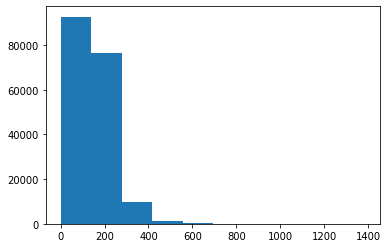

In [121]:
plt.hist(char_lens);

In [123]:
output_seq_char_len=int(np.percentile(char_lens, 95))
output_seq_char_len

290

### Get all keyword characters(Alphanumeric characters)

In [124]:
import string
alphabet= string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [125]:
len(alphabet)

68

### Creating Character Level Token Vectorizer instance

In [135]:
NUM_CHAR_TOKENS= (len(alphabet) + 2) # For "whitespace" and "OOV" token (OOV= Out of Vocabulary, '[UNK])
char_vectorizer= TextVectorization(max_tokens= NUM_CHAR_TOKENS, output_sequence_length= output_seq_char_len, name="char_vectorizer")
char_vectorizer.adapt(train_characters)
char_vectorizer

### Check character vocabulary characteristics

In [136]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")


Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


### Test out character vectorizer

In [137]:
import random

In [138]:
random_train_chars = random.choice(train_characters)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p o s t o p e r a t i v e l y   ,   p a t i e n t s   w e r e   r a n d o m i z e d   i n t o   t h e   c a s e   a n d   c o n t r o l   g r o u p s   .

Length of chars: 66

Vectorized chars:
[[14  7  9  3  7 14  2  8  5  3  4 21  2 12 19 14  5  3  4  2  6  3  9 20
   2  8  2  8  5  6 10  7 15  4 25  2 10  4  6  3  7  3 13  2 11  5  9  2
   5  6 10 11  7  6  3  8  7 12 18  8  7 16 14  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Character Level Embeddings

In [139]:
char_embedding= layers.Embedding(input_dim= len(char_vocab), output_dim=25, mask_zero=True, name="char_embed") # output_dim=25, got it from the paper, Figure 1

### Test out character embedding layer

In [140]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embedding(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p o s t o p e r a t i v e l y   ,   p a t i e n t s   w e r e   r a n d o m i z e d   i n t o   t h e   c a s e   a n d   c o n t r o l   g r o u p s   .

Embedded chars (after vectorization and embedding):
[[[ 0.01818613 -0.00796777 -0.03091056 ...  0.03718961  0.04969156
   -0.04614753]
  [-0.00028883 -0.04054837  0.02683896 ... -0.00558148 -0.0041308
   -0.04855676]
  [ 0.04294782  0.03437591  0.03350068 ...  0.04532513  0.02014948
    0.01527956]
  ...
  [ 0.03425585  0.02931755 -0.04264874 ...  0.04691792  0.03839631
   -0.00389041]
  [ 0.03425585  0.02931755 -0.04264874 ...  0.04691792  0.03839631
   -0.00389041]
  [ 0.03425585  0.02931755 -0.04264874 ...  0.04691792  0.03839631
   -0.00389041]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model with Character Embeddings

In [142]:
inputs= layers.Input(shape=(1,), dtype="string")
x= char_vectorizer(inputs)
x=char_embedding(x)
x=layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x=layers.GlobalAveragePooling1D(name="global_average_pooling1D")(x)
x=layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_3= tf.keras.Model(inputs, outputs, name="conv1D_with_character_embeddings")


In [143]:
model_3.summary()

Model: "conv1D_with_character_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1D (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None

## Making Character Datasets load as fast as possible

In [149]:
train_character_dataset= tf.data.Dataset.from_tensor_slices((train_characters, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_character_dataset= tf.data.Dataset.from_tensor_slices((val_characters, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_character_dataset= tf.data.Dataset.from_tensor_slices((test_characters, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [150]:
train_character_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [151]:
model_3.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_3= model_3.fit(train_character_dataset, steps_per_epoch=int(0.1 * len(train_character_dataset)) ,epochs=5, validation_data=val_character_dataset, validation_steps=int(0.1 * len(val_character_dataset)) ,callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_Conv1D_character_embeddings")])

Saving TensorBoard log files to: model_logs/model_3_Conv1D_character_embeddings/20220826-140924
Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 2.3663 - accuracy: 0.3597 - val_loss: 1.4581 - val_accuracy: 0.3753
Epoch 2/5
562/562 [==============================] - 3s 6ms/step - loss: 1.4427 - accuracy: 0.3771 - val_loss: 1.4381 - val_accuracy: 0.3853
Epoch 3/5
562/562 [==============================] - 3s 6ms/step - loss: 1.4365 - accuracy: 0.3833 - val_loss: 1.4299 - val_accuracy: 0.3826
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 1.4078 - accuracy: 0.3974 - val_loss: 1.3979 - val_accuracy: 0.4013
Epoch 5/5
562/562 [==============================] - 4s 7ms/step - loss: 1.3658 - accuracy: 0.4152 - val_loss: 1.3282 - val_accuracy: 0.4348


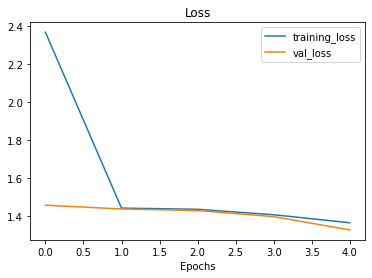

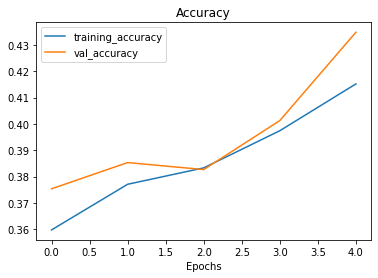

In [152]:
plot_loss_curves(history_3)

In [154]:
model_3_evaluate=model_3.evaluate(val_character_dataset)
model_3_evaluate

945/945 [==============================] - 3s 3ms/step - loss: 1.3301 - accuracy: 0.4339


[1.330128788948059, 0.4339004456996918]

In [155]:
model_3_pred_probs= model_3.predict(val_character_dataset)
model_3_pred_probs

array([[0.13933164, 0.16500627, 0.38287467, 0.09879551, 0.21399194],
       [0.11025786, 0.14315376, 0.32306758, 0.04572268, 0.37779814],
       [0.14603512, 0.156864  , 0.42808992, 0.09754412, 0.17146686],
       ...,
       [0.04047175, 0.06411573, 0.28986543, 0.02741955, 0.57812756],
       [0.04691456, 0.10223045, 0.23429917, 0.04585638, 0.57069945],
       [0.12432314, 0.15851556, 0.340614  , 0.05512137, 0.32142594]],
      dtype=float32)

In [156]:
model_3_preds= tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 4, 2, ..., 4, 4, 2])>

In [158]:
model_3_results= calculate_results(val_labels_encoder, model_3_preds)
model_3_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 43.39004369124851,
 'precision': 0.3816810121085107,
 'recall': 0.4339004369124851,
 'f1': 0.3653979951430899}

## Model 3_1: Building a Conv1D model with Character Embeddings

In [159]:
inputs= layers.Input(shape=(1,), dtype="string")
x= char_vectorizer(inputs)
x=char_embedding(x)
x=layers.Conv1D(64, 5, padding="same", activation="relu")(x)
x=layers.GlobalMaxPooling1D(name="global_max_pooling1D")(x)
x=layers.Dense(64, activation="relu")(x)
outputs= layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_3_1= tf.keras.Model(inputs, outputs, name="conv1D_with_character_embeddings")

In [160]:
model_3_1.summary()

Model: "conv1D_with_character_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1D (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None

In [161]:
model_3_1.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(), metrics=["accuracy"])
history_3_1= model_3_1.fit(train_character_dataset, steps_per_epoch=int(0.1 * len(train_character_dataset)) ,epochs=5, validation_data=val_character_dataset, validation_steps=int(0.1 * len(val_character_dataset)) ,callbacks=[create_tensorboard_callback(SAVE_DIR, "model_3_Conv1D_character_embeddings_with_max_pooling")])

Saving TensorBoard log files to: model_logs/model_3_Conv1D_character_embeddings_with_max_pooling/20220826-141652
Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.3024 - accuracy: 0.4387 - val_loss: 1.1248 - val_accuracy: 0.5090
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0790 - accuracy: 0.5510 - val_loss: 0.9931 - val_accuracy: 0.5801
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9755 - accuracy: 0.5976 - val_loss: 0.9134 - val_accuracy: 0.6200
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9132 - accuracy: 0.6296 - val_loss: 0.9078 - val_accuracy: 0.6273
Epoch 5/5
562/562 [==============================] - 4s 6ms/step - loss: 0.8940 - accuracy: 0.6427 - val_loss: 0.8888 - val_accuracy: 0.6466


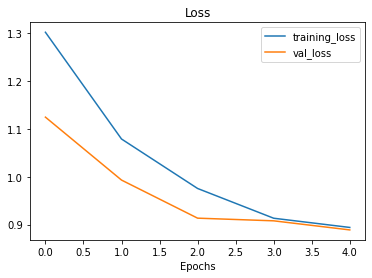

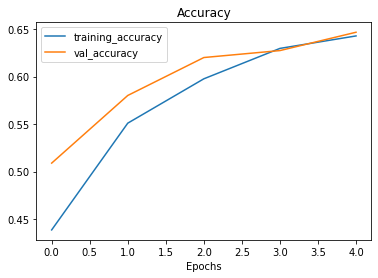

In [162]:
plot_loss_curves(history_3_1)

In [163]:
model_3_1_evaluate=model_3_1.evaluate(val_character_dataset)
model_3_1_evaluate

945/945 [==============================] - 4s 4ms/step - loss: 0.9032 - accuracy: 0.6452


[0.9031614065170288, 0.6451740860939026]

In [164]:
model_3_1_pred_probs= model_3_1.predict(val_character_dataset)
model_3_1_pred_probs

array([[0.27088305, 0.45313743, 0.02297953, 0.2384783 , 0.01452172],
       [0.31621617, 0.4835073 , 0.00605767, 0.18624608, 0.00797281],
       [0.24058445, 0.31420565, 0.06171946, 0.3737301 , 0.00976038],
       ...,
       [0.01200212, 0.02331587, 0.11756855, 0.01265093, 0.8344625 ],
       [0.03788975, 0.1004228 , 0.67744964, 0.02851446, 0.15572338],
       [0.30795288, 0.5970484 , 0.01585411, 0.06404332, 0.01510131]],
      dtype=float32)

In [165]:
model_3_1_preds= tf.argmax(model_3_1_pred_probs, axis=1)
model_3_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 2, 1])>

In [166]:
model_3_1_results= calculate_results(val_labels_encoder, model_3_1_preds)
model_3_1_results

{'accuracy': 64.51741030054283,
 'precision': 0.6780072602079501,
 'recall': 0.6451741030054283,
 'f1': 0.6519892688445893}

In [167]:
model_3_results

{'accuracy': 43.39004369124851,
 'precision': 0.3816810121085107,
 'recall': 0.4339004369124851,
 'f1': 0.3653979951430899}

In [168]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [169]:
model_2_results

{'accuracy': 68.76737720111214,
 'precision': 0.6790364740175273,
 'recall': 0.6876737720111215,
 'f1': 0.6782531204502598}